In [1]:
!pip install pyyaml h5py

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
import keras
import tensorflow as tf
from tensorflow.keras import layers
import cv2

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML")

In [7]:
data_path = "/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/sharePublic/Public"
dataset_path = "/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public"
col_name = ['ImageFullPath', 'CategoryID']
AUTOTUNE = tf.data.AUTOTUNE
img_height = 128
img_width = 128
car_brands = ['Others', 'Honda', 'Hyundai', 'KIA', 'Mazda', 'Mitsubishi', 'Suzuki', 'Toyota', 'VinFast']
categories = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8,
}

# Preprocess dataset

---



In [8]:
train_df = pd.read_csv(dataset_path + '/CarDataset-Splits-2-Train.csv')
test_df = pd.read_csv(dataset_path + '/CarDataset-Splits-2-Test.csv')

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df[col_name[0]].values, train_df[col_name[1]].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df[col_name[0]].values, test_df[col_name[1]].values))

In [10]:
def read_image(image_path):
    img = tf.io.read_file(data_path + '/'+ image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.squeeze(img)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [img_height, img_width])
    return img

In [11]:
# num_parallel_calls=tf.data.AUTOTUNE: optimize the data processing performance
train_ds = train_dataset.map(lambda path, category_id: (read_image(path), tf.cast(category_id, tf.int32)))
test_ds = test_dataset.map(lambda path, category_id: (read_image(path), tf.cast(category_id, tf.int32)))

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
train_ds = train_ds.map(lambda path, category_id: (normalization_layer(path), category_id), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda path, category_id: (normalization_layer(path), category_id), num_parallel_calls=AUTOTUNE)

In [14]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

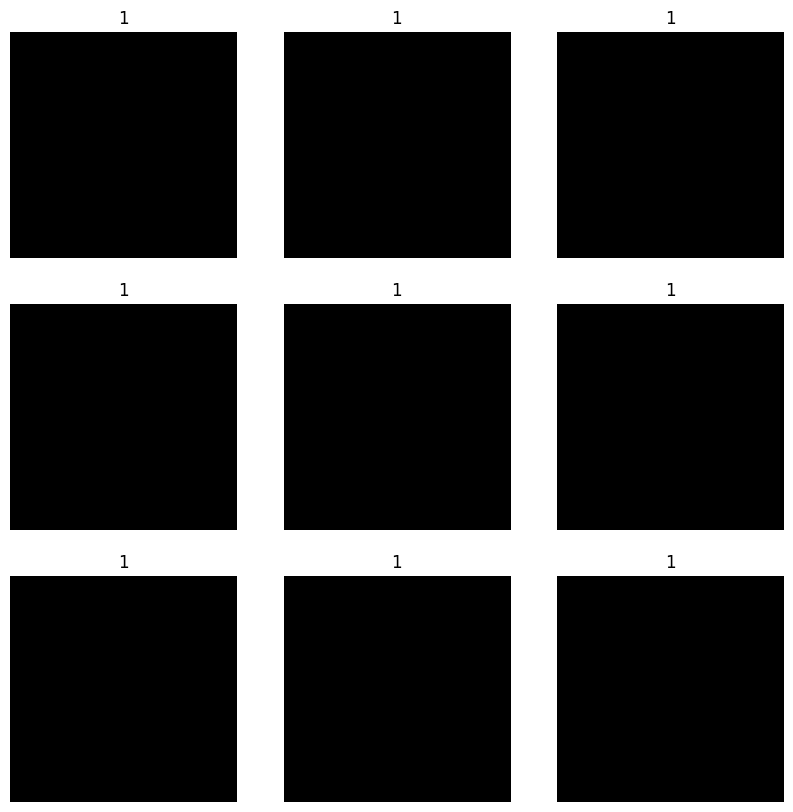

In [ ]:
#Khong chay cai nay

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
#Khong chay cai nay
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [ ]:
#Khong chay cai nay
for image_batch, labels_batch in train_ds:
  print(image_batch.numpy())
  print(labels_batch.numpy())
  break

[[[[0.40874696 0.5686275  0.7019608 ]
   [0.40874696 0.5686275  0.7019608 ]
   [0.4156863  0.57254905 0.7058824 ]
   ...
   [0.43307796 0.60170543 0.7311172 ]
   [0.44796264 0.6009038  0.7303156 ]
   [0.44176987 0.59471107 0.7241228 ]]

  [[0.40214464 0.5707721  0.70018387]
   [0.4039216  0.57254905 0.7019608 ]
   [0.41176474 0.5686275  0.7019608 ]
   ...
   [0.42895222 0.6        0.7282016 ]
   [0.43310955 0.5990256  0.7294118 ]
   [0.427451   0.59336704 0.7254902 ]]

  [[0.40000004 0.5686275  0.69803923]
   [0.40000004 0.5686275  0.69803923]
   [0.41176474 0.5686275  0.7019608 ]
   ...
   [0.42352945 0.5966759  0.72881436]
   [0.40963545 0.5927543  0.71824455]
   [0.4057139  0.58883274 0.714323  ]]

  ...

  [[0.41788188 0.41003874 0.42964658]
   [0.41743264 0.4095895  0.42919734]
   [0.39968815 0.39184502 0.41145286]
   ...
   [0.10588236 0.12156864 0.13333334]
   [0.10196079 0.11764707 0.12941177]
   [0.10196079 0.11764707 0.12941177]]

  [[0.35686275 0.34901962 0.36862746]
   [0.3

In [15]:
train_ds = train_ds.cache()
test_ds = test_ds.cache()

In [16]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
save_path = "/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/SaveModel"
checkpoint_path = os.path.join(save_path, "cp.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)

In [22]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [29]:
model = tf.keras.models.load_model(os.path.join(save_path, "my_model.keras"))

In [24]:
# Da co model san, khong can khoi tao lai


# num_category = len(car_brands)

# model = Sequential([
#   data_augmentation,
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_category)
# ])

In [25]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,366,077 (24.28 MB)

 Trainable params: 2,122,025 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,244,052 (16.19 MB)

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0705 - loss: 2.2666
Epoch 1: saving model to /content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/SaveModel/cp.weights.h5
803/803 ━━━━━━━━━━━━━━━━━━━━ 4546s 6s/step - accuracy: 0.0707 - loss: 2.2665 - val_accuracy: 0.0676 - val_loss: 194.1526
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.8095 - loss: 10.8167
Epoch 2: saving model to /content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/SaveModel/cp.weights.h5
803/803 ━━━━━━━━━━━━━━━━━━━━ 555s 691ms/step - accuracy: 0.8094 - loss: 10.8090 - val_accuracy: 0.1632 - val_loss: 2.4972
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.0586 - loss: 2.3276
Epoch 3: saving model to /content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/SaveModel/cp.weights.h5
803/803 ━━━━━━━━━━━━━━━━━━━━ 553s 688ms/step - accuracy: 0.0587 - loss: 2.3275 - val_accuracy: 0.1987 - val_loss: 2.1476
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 645m

In [36]:
history.model.save(save_path + '/my_model.keras')